In [1]:
import os
import cPickle
from dataset import Dataset
import numpy as np
from numpy.random import RandomState
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from tsne import bh_sne
import matplotlib.pyplot as plt

import tensorflow as tf
tf.python.control_flow_ops = tf

Using TensorFlow backend.


In [2]:
def VGG16(include_top=True):
    '''Instantiate the VGG16 architecture,
    loading weights pre-trained on ImageNet.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
    # Returns
        A Keras model instance.
    '''
   
    # Set proper input shape
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = Flatten(name='flatten')(x)
    
    if include_top:
        # Classification block
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(1000, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(img_input, x)

    # load weights
    if include_top:
        weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    else:
        weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model.load_weights(weights_path)
    return model

In [3]:
def savetsne(X, y, classes, pca_d=None):
    print("Running t-SNE ...")
    vis_data = bh_sne(np.float64(X), d=2, pca_d=pca_d, perplexity=30., theta=0.5, random_state=RandomState(1))
    print("Plotting t-SNE ...")
    figure = plt.gcf()
    figure.set_size_inches(24, 18)
    plt.scatter(vis_data[:, 0], vis_data[:, 1], c=y, cmap=plt.cm.get_cmap("Set1", len(classes)))
    plt.clim(-0.5, len(classes)-0.5)
    cbar = plt.colorbar(ticks=range(len(classes)))
    cbar.ax.set_yticklabels(classes)                     
    plt.show()

In [4]:
dataset = 'cg-iluminants.pkl'
print("Loading dataset from %s ..." %(dataset))
ds = Dataset()
X, y, classes, no_imgs = ds.load(dataset)

Loading dataset from cg-iluminants.pkl ...


In [5]:
X.shape

(15537, 150528)


Building t-SNE plot for raw input ...
Running t-SNE ...
Plotting t-SNE ...


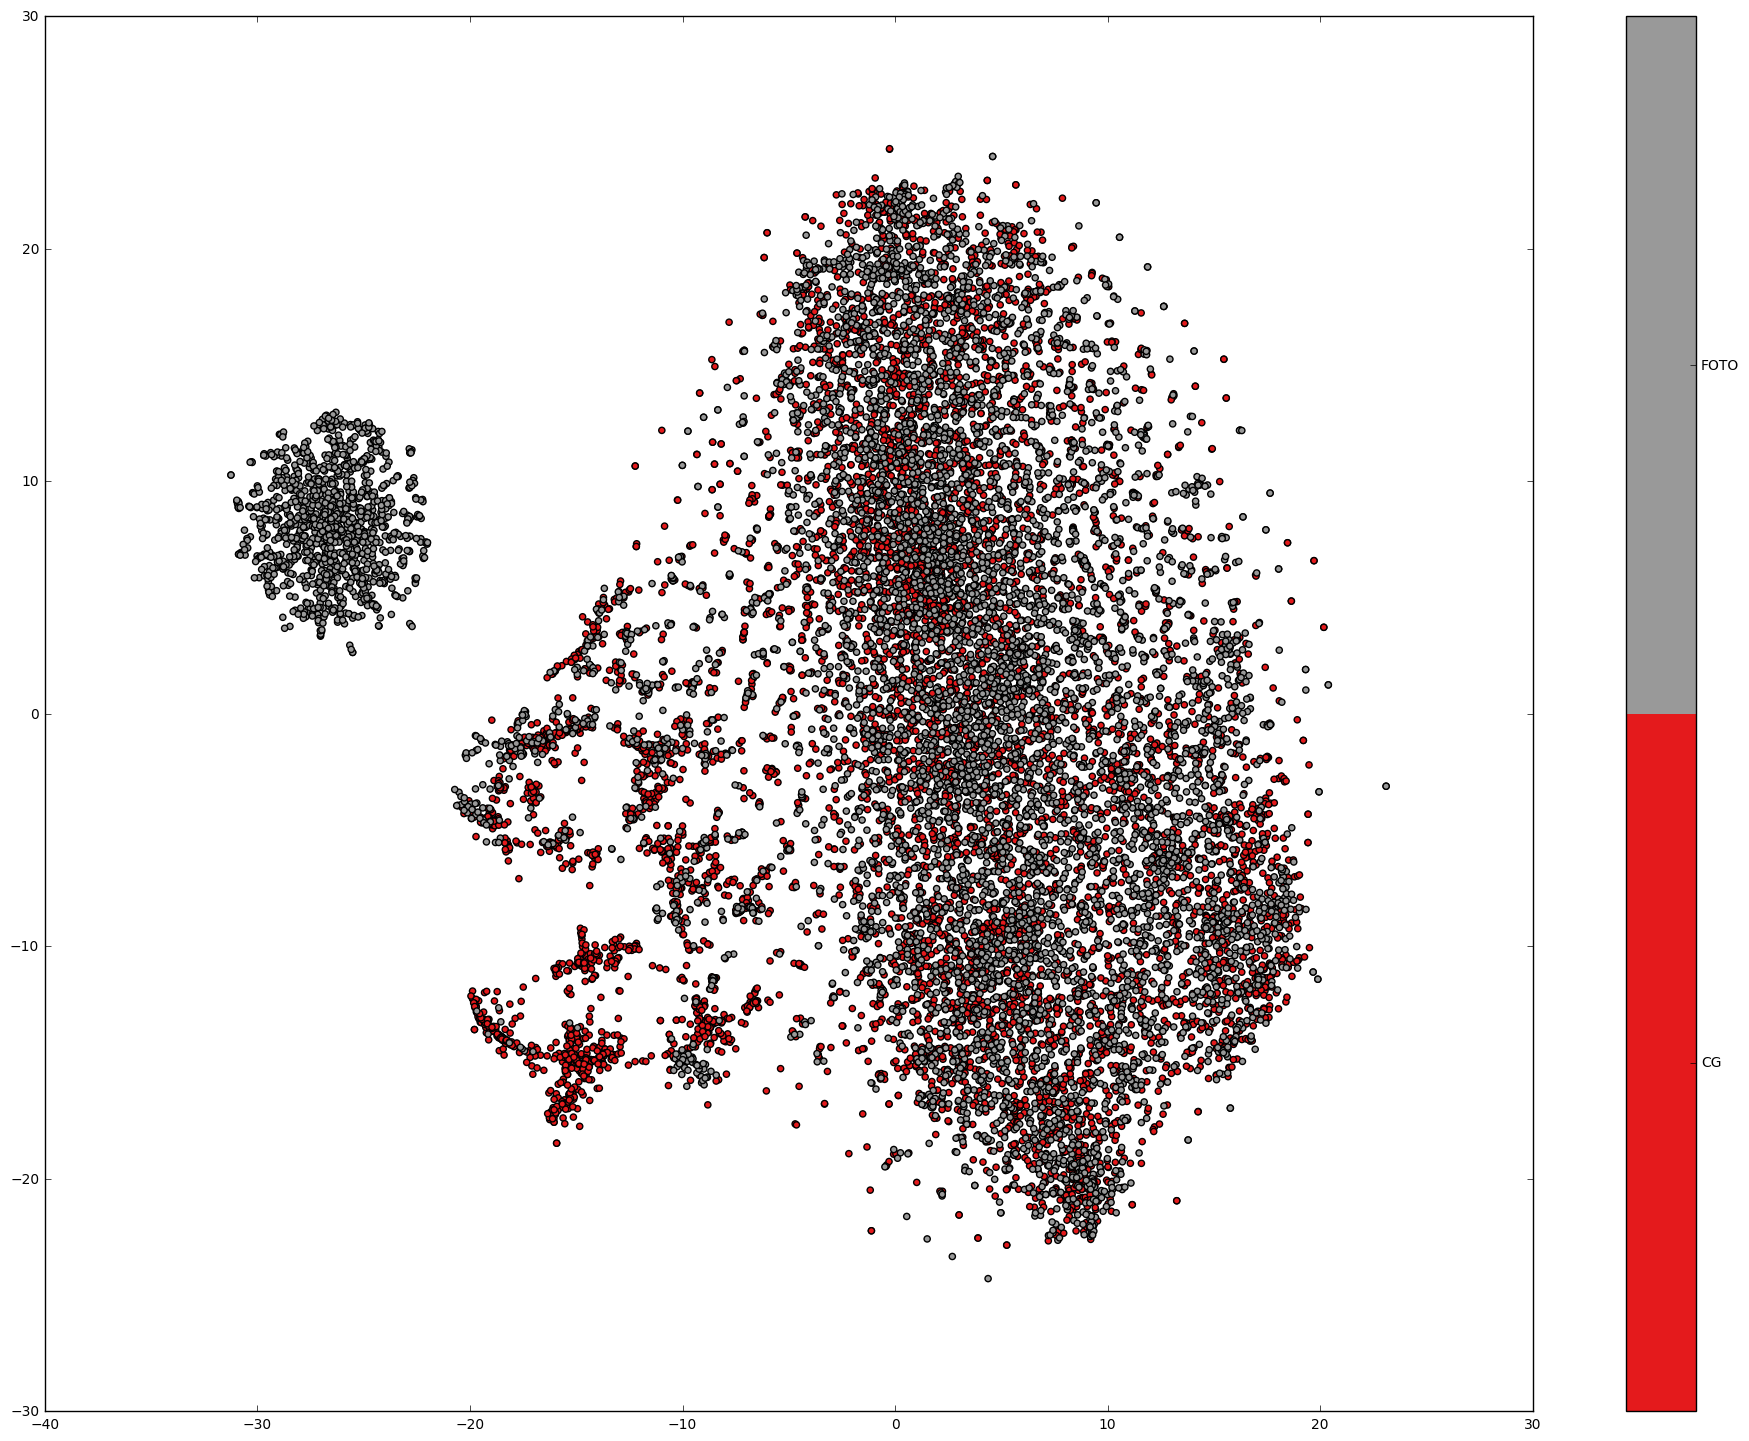

In [9]:
print("\nBuilding t-SNE plot for raw input ...")
savetsne(X, y, classes)

In [6]:
dataset = 'vgg16-cg-iluminants.pkl'
if os.path.exists(dataset):
    print("Loading VGG16 features from %s ..." %(dataset))
    ds = Dataset()
    vgg16features, y, classes, no_imgs = ds.load(dataset)
else:
    print("\nBuilding VGG16 model ...")
    model = VGG16(include_top=False)
    input_shape = (224, 224, 3)
    
    # TODO
    ################################
    w, h = X.shape
    Xprocessed = X.reshape(w, input_shape[0], input_shape[1], input_shape[2]).astype('float32')/255
    vgg16features = model.predict(Xprocessed)
    ################################
    
    print("\nSaving VGG16 extracted features in file %s ..." %(dataset))
    vggdataset = (vgg16features, y, classes, no_imgs)
    f = open(dataset, 'wb')
    cPickle.dump(vggdataset, f)
    f.close()


Building VGG16 model ...

Saving VGG16 extracted features in file vgg16-cg-iluminants.pkl ...


In [7]:
vgg16features.shape

(15537, 25088)


Building t-SNE plot for VGG16 features ...
Running t-SNE ...
Plotting t-SNE ...


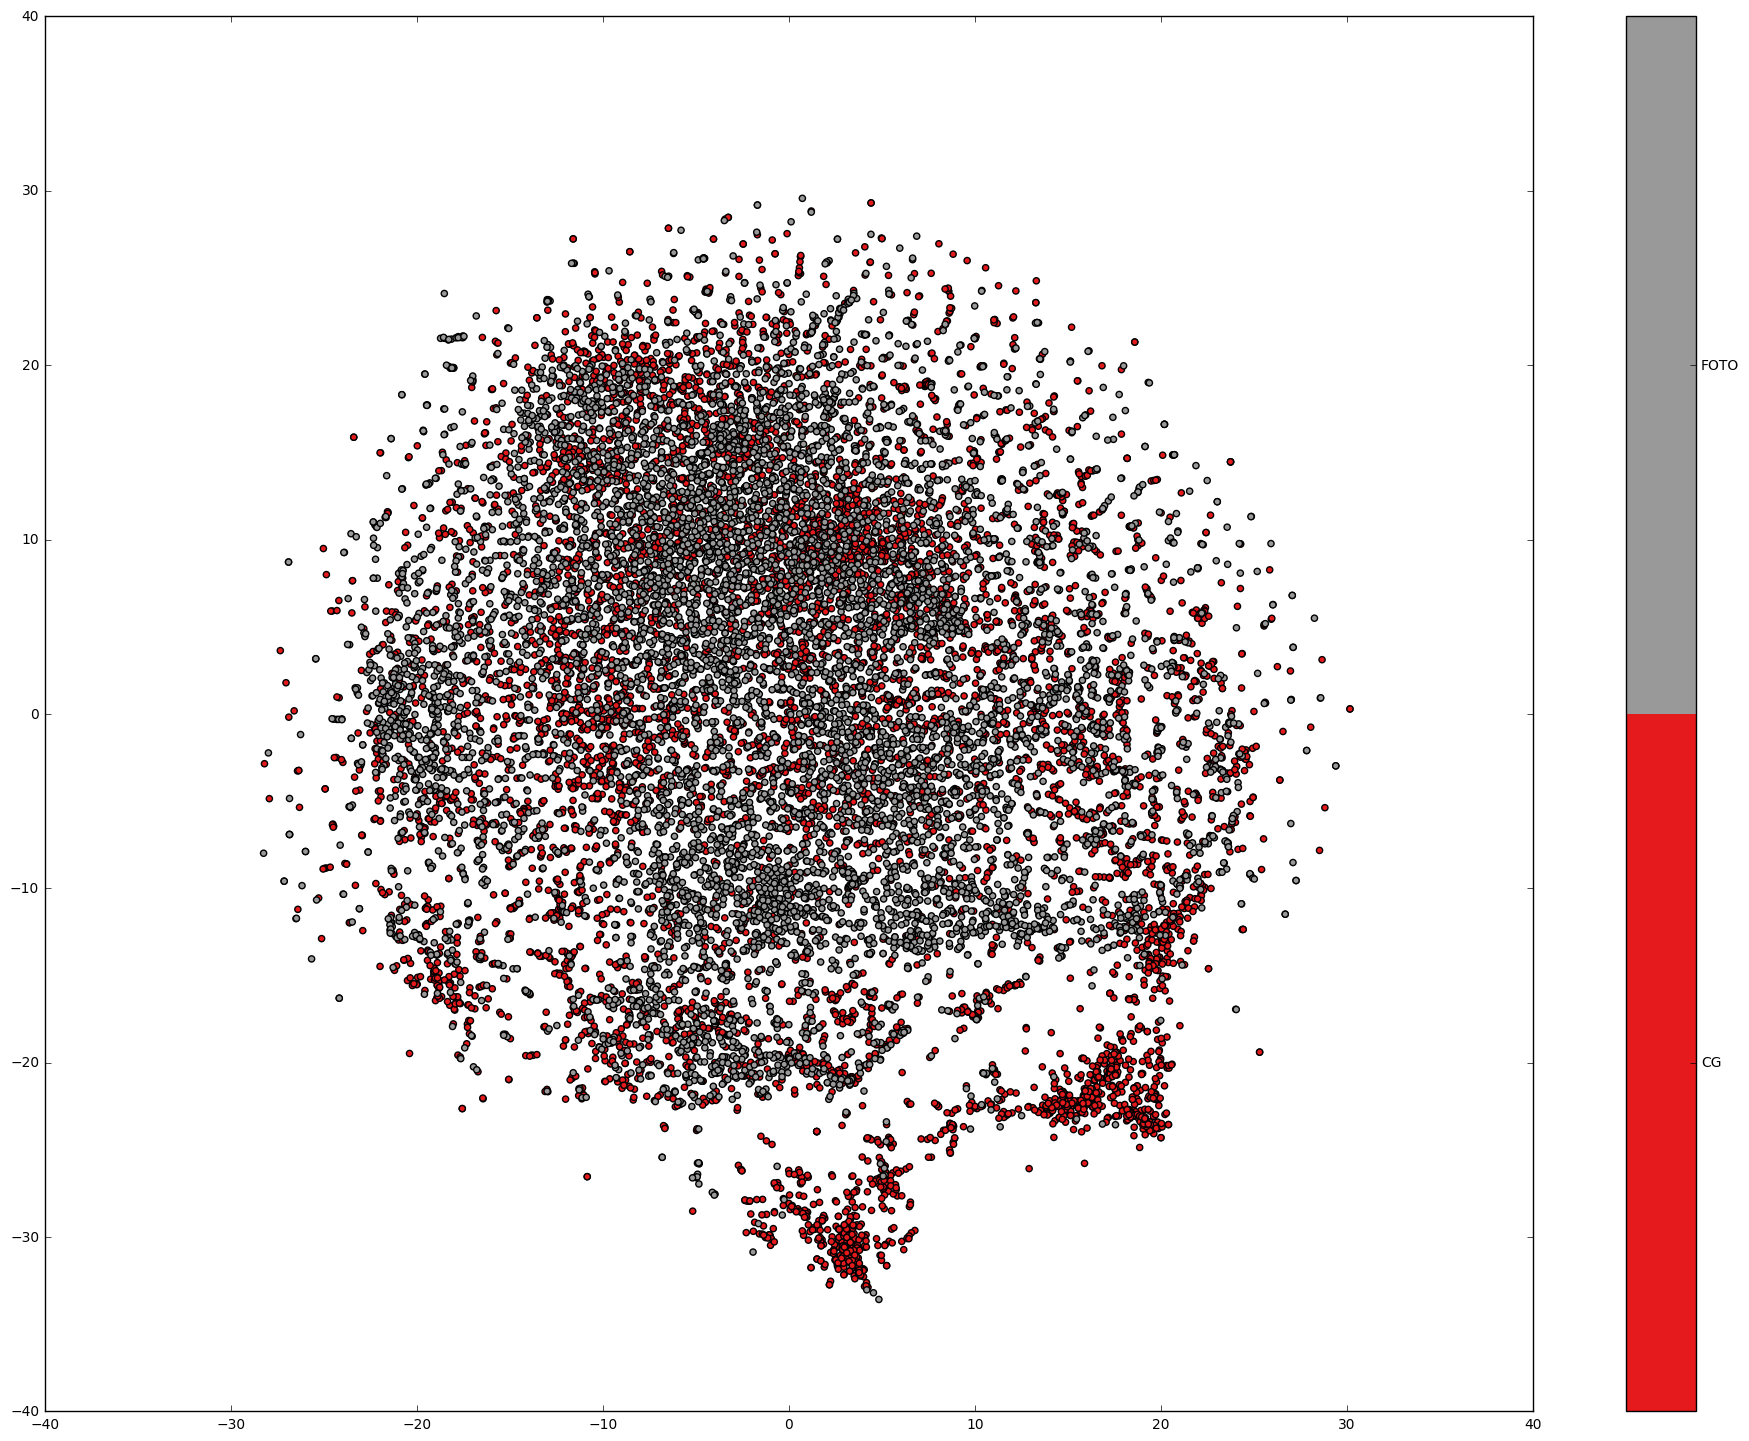

In [8]:
print("\nBuilding t-SNE plot for VGG16 features ...")
savetsne(vgg16features, y, classes)